In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from torchvision.models import vgg16_bn
import PIL
import imageio
from utils import *
from scipy.ndimage.interpolation import zoom as npzoom
from skimage.util import img_as_float32, img_as_ubyte
from skimage.measure import compare_ssim, compare_psnr

In [2]:
torch.cuda.set_device(1)
nb_name='emsynth_005_unet'

In [4]:
img_data = Path('/scratch/bpho/datasets/emsynth_003/')
model_path = Path('/scratch/bpho/models')

In [5]:
!ls {model_path}/{nb_name}*

/scratch/bpho/models/emsynth_005_unet.0.pth
/scratch/bpho/models/emsynth_005_unet.1.pth
/scratch/bpho/models/emsynth_005_unet.5.pth


In [10]:
def get_src():
    hr_tifs = img_data/f'hr'
    lr_tifs = img_data/f'lr_up'

    def map_to_hr(x):
        hr_name = x.relative_to(lr_tifs)
        return hr_tifs/hr_name
    print(lr_tifs)
    src = (ImageImageList
            .from_folder(lr_tifs)
            .split_by_rand_pct()
            .label_from_func(map_to_hr))
    return src


def get_data(bs, size, noise=None, max_zoom=1.1):
    src = get_src()
    tfms = get_transforms(flip_vert=True, max_zoom=max_zoom)
    data = (src
            .transform(tfms, size=size)
            .transform_y(tfms, size=size)
            .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data


In [11]:
bs = 64
size = 128
data = get_data(bs, size, max_zoom=6)
data

/scratch/bpho/datasets/emsynth_003/lr_up


ImageDataBunch;

Train: LabelList (800 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /scratch/bpho/datasets/emsynth_003/lr_up;

Valid: LabelList (200 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /scratch/bpho/datasets/emsynth_003/lr_up;

Test: None

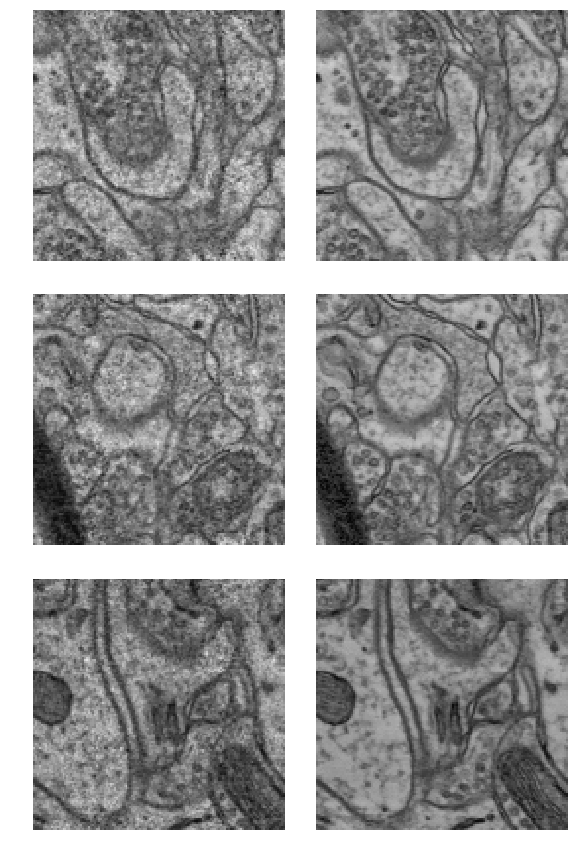

In [12]:
data.show_batch(3, ds_type=DatasetType.Valid)

In [13]:
arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, 
                     loss_func=F.mse_loss,
                     metrics=superres_metrics, 
                     blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

11922

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [40]:
lr = 1e-3

In [41]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9, cycle_len=10):
    learn.fit_one_cycle(cycle_len, lrs, pct_start=pct_start)
    learn.save(save_name)
    num_rows = min(learn.data.batch_size, 3)
    learn.show_results(rows=num_rows, imgsize=5)

In [ ]:
do_fit(f'{nb_name}.0', lr, cycle_len=1)

In [ ]:
learn.unfreeze()

In [ ]:
do_fit(f'{nb_name}.1', slice(1e-5,lr), cycle_len=1)

In [ ]:
bs = 16
size = 256
data = get_data(bs, size, max_zoom=3)

arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, 
                     #loss_func=feat_loss,
                     loss_func=F.mse_loss,
                     metrics=superres_metrics, 
                     #callback_fns=LossMetrics, 
                     blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

learn = learn.load(f'{nb_name}.3')

In [ ]:
do_fit('emsynth_003_unet.2', lr, cycle_len=3)

In [ ]:
learn.unfreeze()

In [ ]:
do_fit(f'{nb_name}.3a', slice(1e-5,lr), cycle_len=3)  

In [ ]:
print('cool ')

In [ ]:
bs = 8 
size = 512
data = get_data(bs, size, max_zoom=2.)

arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, 
                     #loss_func=feat_loss,
                     loss_func=F.mse_loss,
                     metrics=superres_metrics, 
                     #callback_fns=LossMetrics, 
                     blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

learn = learn.load(f'{nb_name}.3a')

In [ ]:
do_fit('{nb_name}.4', lr, cycle_len=3)

In [ ]:
learn.unfreeze()

In [ ]:
do_fit(f'{nb_name}.5', slice(1e-5,lr/10), cycle_len=3)

In [ ]:
bs = 2
size = 1024
data = get_data(bs, size, max_zoom=1.5)

arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=superres_metrics, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

learn = learn.load(f'{nb_name}.5')

In [ ]:
do_fit(f'{nb_name}.6', lr/100000, cycle_len=4)

In [ ]:
learn.unfreeze()

In [ ]:
do_fit(f'{nb_name}.7', slice(1e-5,lr), cycle_len=10)

In [ ]:
bs = 1
size = 1024
data = get_data(bs, size)

arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=superres_metrics, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

learn = learn.load(f'{nb_name}.6').to_fp16()

In [ ]:
learn.unfreeze()
do_fit(f'{nb_name}.8', slice(1e-6,1e-5), cycle_len=10)

In [ ]:
do_fit(f'{nb_name}.9', slice(1e-6,1e-5), cycle_len=1)

In [ ]:
#!ls /scratch/bpho/models

In [10]:
bs = 1
#size = 1920
size = 300*4
data = get_data(bs, size)

arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=superres_metrics, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

learn = learn.load(f'{nb_name}.5').to_fp16()

/scratch/bpho/datasets/emsynth_003/lr_up


In [11]:
test_files = Path('/scratch/bpho/datasources/EM_manually_aquired_pairs_01242019/')
test_hr = list((test_files/'aligned_hr').glob('*.tif'))
test_lr = list((test_files/'aligned_lr').glob('*.tif'))
results = Path('/scratch/bpho/results/emsynth_crap')

if results.exists(): shutil.rmtree(results)
results.mkdir(parents=True, mode=0o775, exist_ok=True)

def get_key(fn):
    return fn.stem[0:(fn.stem.find('Region')-1)]

hr_map = { get_key(fn): fn for fn in test_hr }
lr_map = { get_key(fn): fn for fn in test_lr }


In [7]:
test_path = Path('/home/bpho/Documents/test/3ViewBrain_8x8x80nm-px_scaled/')
#test_path = Path('/home/bpho/Documents/test/EM_manual_pairs/')
#test_hr = list(test_path.glob('*.tif'))
test_lr = list(test_path.glob('*.tif'))
results = Path('/home/bpho/Documents/test/3ViewBrain_8x8x80nm-px_scaled/results')

if results.exists(): shutil.rmtree(results)
results.mkdir(parents=True, mode=0o775, exist_ok=True)

def get_key(fn):
    return fn.stem[-2:]

#hr_map = { get_key(fn): fn for fn in test_hr }
lr_map = { get_key(fn): fn for fn in test_lr }
len(lr_map)

1

In [63]:
test_path = Path('/home/bpho/Documents/test/3ViewBrain_8x8x100nm-vx/8-bit')
test_files = list(test_path.glob('*.tif'))
results = test_path/'results'
if results.exists(): shutil.rmtree(results)
results.mkdir(parents=True, mode=0o775, exist_ok=True)
test_files

[PosixPath('/home/bpho/Documents/test/3ViewBrain_8x8x100nm-vx/8-bit/3ViewBrain_8x8x100nm-vx0020.tif'),
 PosixPath('/home/bpho/Documents/test/3ViewBrain_8x8x100nm-vx/8-bit/3ViewBrain_8x8x100nm-vx0051.tif'),
 PosixPath('/home/bpho/Documents/test/3ViewBrain_8x8x100nm-vx/8-bit/3ViewBrain_8x8x100nm-vx0068.tif'),
 PosixPath('/home/bpho/Documents/test/3ViewBrain_8x8x100nm-vx/8-bit/3ViewBrain_8x8x100nm-vx0034.tif'),
 PosixPath('/home/bpho/Documents/test/3ViewBrain_8x8x100nm-vx/8-bit/3ViewBrain_8x8x100nm-vx0005.tif'),
 PosixPath('/home/bpho/Documents/test/3ViewBrain_8x8x100nm-vx/8-bit/3ViewBrain_8x8x100nm-vx0063.tif'),
 PosixPath('/home/bpho/Documents/test/3ViewBrain_8x8x100nm-vx/8-bit/3ViewBrain_8x8x100nm-vx0053.tif'),
 PosixPath('/home/bpho/Documents/test/3ViewBrain_8x8x100nm-vx/8-bit/3ViewBrain_8x8x100nm-vx0074.tif'),
 PosixPath('/home/bpho/Documents/test/3ViewBrain_8x8x100nm-vx/8-bit/3ViewBrain_8x8x100nm-vx0030.tif'),
 PosixPath('/home/bpho/Documents/test/3ViewBrain_8x8x100nm-vx/8-bit/3View

In [64]:
bs = 1
size = 240*4
#size = 128*4
#size = 1024
data = get_data(bs, size)

arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=superres_metrics, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()
learn = learn.load(f'{nb_name}.5').to_fp16()

/scratch/bpho/datasets/emsynth_003/lr_up


In [65]:
import libtiff
import skimage
for fn in test_files:
    pred_name = str(results/f'{fn.stem}_pred')
    orig_name = results/f'{fn.stem}_orig.tif'
    tif_predict_movie(learn, fn, size=size, orig_out=orig_name, pred_out=pred_name )

In [8]:
def image_from_tiles(learn, img, tile_sz=128, scale=4):
    pimg = PIL.Image.fromarray((img*255).astype(np.uint8), mode='L').convert('RGB')
    cur_size = pimg.size
    new_size = (cur_size[0]*scale, cur_size[1]*scale)
    in_img = Image(pil2tensor(pimg.resize(new_size, resample=PIL.Image.BICUBIC),np.float32).div_(255))
    c, w, h = in_img.shape
    
    in_tile = torch.zeros((c,tile_sz,tile_sz))
    out_img = torch.zeros((c,w,h))
    
    for x_tile in range(math.ceil(w/tile_sz)):
        for y_tile in range(math.ceil(h/tile_sz)):
            x_start = x_tile

            x_start = x_tile*tile_sz
            x_end = min(x_start+tile_sz, w)
            y_start = y_tile*tile_sz
            y_end = min(y_start+tile_sz, h)
            
            
            in_tile[:,0:(x_end-x_start), 0:(y_end-y_start)] = in_img.data[:,x_start:x_end, y_start:y_end]
            
            out_tile,_,_ = learn.predict(Image(in_tile))

            out_x_start = x_start
            out_x_end = x_end
            out_y_start = y_start
            out_y_end = y_end

            #print("out: ", out_x_start, out_y_start, ",", out_x_end, out_y_end)
            in_x_start = 0
            in_y_start = 0
            in_x_end = x_end-x_start
            in_y_end = y_end-y_start
            #print("tile: ",in_x_start, in_y_start, ",", in_x_end, in_y_end)
           
            out_img[:,out_x_start:out_x_end, out_y_start:out_y_end] = out_tile.data[:,
                                                                                  in_x_start:in_x_end, 
                                                                                  in_y_start:in_y_end]
    return out_img

In [9]:
def tif_predict_movie(learn, tif_in, orig_out='orig.tif', pred_out='pred.tif', size=128):
        data = libtiff.TiffFile(tif_in)
        data = data.get_tiff_array()
        depths = data.shape[0]
        img_max = None
        preds = []
        origs = []
        for depth in progress_bar(list(range(depths))):
            img = data[depth].astype(np.float32)
            if img_max is None: img_max = img.max() * 1.0
            img /= img_max
            out_img = image_from_tiles(learn, img, tile_sz=size).permute([1,2,0])
            pred = (out_img[None]*255).cpu().numpy().astype(np.uint8)
            pred_img_out = pred_out+f'_slice{depth}.tif'
            skimage.io.imsave(pred_img_out,pred[0,:,:,:])

In [14]:
ssims = []
psnrs = []
for k in progress_bar(lr_map):
    lr_fn = lr_map[k]
    #hr_fn, lr_fn = hr_map[k], lr_map[k]
    #print(hr_fn, lr_fn)+
    #hr_img = PIL.Image.open(hr_fn)
    lr_img = PIL.Image.open(lr_fn)
    lr_img_data = img_as_float32(lr_img)
    lr_up_data = npzoom(lr_img_data, 4, order=1)
    lr_up_img = Image(tensor(lr_up_data[None]))
    hr_pred_img, aaa, bbb = learn.predict(lr_up_img)
    pred_img = PIL.Image.fromarray(img_as_ubyte(np.array(hr_pred_img.data))[0,:,:])
    
    #lr_img.save(results/f'{k}_orig.tif')
    #hr_img.save(results/f'{k}_truth.tif')
    pred_img.save(results/f'{k}_pred.tif')
    #hr_img_data = np.array(hr_img)
    
    #ssims.append(compare_ssim(img_as_float32(np.array(hr_img)), img_as_float32(np.array(pred_img))))
    #psnrs.append(compare_psnr(img_as_float32(np.array(hr_img)), img_as_float32(np.array(pred_img))))

/home/bpho/.conda/envs/fastai/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [ ]:
np.array(ssims).mean(), np.array(psnrs).mean()

In [ ]:
import skimage.io as io

#target_path = Path('/DATA/Dropbox/bpho_movie_results/emsynth_003/')
target_path = results

orig,tru,pred = [list(target_path.glob(f'*{tag}*')) for tag in ['orig','tru','pred']]
orig.sort()
tru.sort()
pred.sort()


ssims = []
c_ssims = []
l_ssims = []
psnrs = []
c_psnrs = []
l_psnrs = []

for o, t,p in progress_bar(list(zip(orig, tru,pred))):
    oimg, timg, pimg = [img_as_float32(io.imread(fn)) for fn in [o,t,p]]
    if len(pimg.shape) == 3: pimg = pimg[:,:,0]
    cimg = npzoom(oimg, 4)
    limg = npzoom(oimg, 4, order=1)
    
    ssims.append(compare_ssim(timg, pimg))
    c_ssims.append(compare_ssim(timg, cimg))
    l_ssims.append(compare_ssim(timg, limg))
    psnrs.append(compare_psnr(timg, pimg))
    c_psnrs.append(compare_psnr(timg, cimg))
    l_psnrs.append(compare_psnr(timg, limg))
    
import pandas as pd

df = pd.DataFrame(dict(ssim=ssims, psnr=psnrs, 
                        bicubic_ssim=c_ssims, bicubic_psnr=c_psnrs,
                        bilinear_ssim=l_ssims, bilinear_psnr=l_psnrs))

df.describe()